# Colegio de Postgraduados Campus Montecillo
## Posgrado en Socioeconomía, Estadística e Informática
## Cómputo Aplicado

## Árbol de decisión para el conjunto de datos original

Por: Ulises Enrique Campos Ferreira

### Importar las librerías necesarias 

In [2]:
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

### Optimización de hiperparámetros

Para este caso, solamente se cargaron las tasas relativas mediante la predicción realizada al algoritmo de <i>Random Forest</i>.

Se hizo una partición de los datos de $80:20$; es decir, $80\%$ para el conjunto de entrenamiento y $20\%$ para el conjunto de validación. Esto solamente se hizo para obtener los mejores hiperparámetros.

In [3]:
ruta = "/Users/campos/Documents/COA 690/Segundo entrenamiento/"
os.chdir(ruta)

datos = pd.read_csv("CART RF.csv")

X = datos.iloc[:, :3].values

y = datos.iloc[:, 3].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                    random_state = 1, stratify = y)

In [4]:
datos.head()

,Porcentaje S,Porcentaje R,Porcentaje A,Clase
0,78.35,0.41,21.24,A
1,87.78,0.04,12.18,A
2,73.77,0.12,26.11,A
3,88.65,0.17,11.18,A
4,92.30,0.07,7.64,A


Los datos solamente contienen los porcentajes pertenecientes a cada clase, de las 90 imágenes; así como su clase obvervada.

### Búsqueda por retícula

La función `DecisionTreeClassifier`comparte los mismos hiperparámetros que <i>Random Forest</i>, debido a que el conjunto de árboles de decisión se obtiene el bosque aleatorio.

Como el conjunto de datos es muy pequeño, se definió un rango más amplio de hiperparámetros a evaluar. De igual forma se definió una validación cruzada $k = 10$ 

In [5]:
param_grid = {
    'max_depth': [3, 4, 5, 7],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 3, 4],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_features': [None, 'sqrt', 'log2']
}


arbol = DecisionTreeClassifier()

gs = GridSearchCV(arbol, 
                  param_grid,scoring='accuracy', 
                  n_jobs= -1,
                  refit = True,
                  cv=10)


gs = gs.fit(X_train, y_train)


gs.best_params_

{'criterion': 'log_loss',
 'max_depth': 7,
 'max_features': None,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'splitter': 'random'}

A pesar de que la grid search haya entregado esos valores de hiperparámetros, se probó con los que se tienen a continuación; ya que al hacer la evaluación, se obtuvo mejores resultados. Puedes comprobarlo por ti mismo.

In [18]:
modelo = DecisionTreeClassifier(criterion = 'gini',
                                max_depth = 7,
                                max_features = None,
                                min_samples_leaf = 1,
                                min_samples_split = 8,
                                splitter = 'random',
                                random_state = 1)

### Entrenamiento con el $100 \%$ de datos

A continuación se realizará la evaluación con los hiperparámetros optimizados, pero con la totalidad de los datos, para esto se utilizará la función `StratifiedKFold`, que se encargará de hacer de igual forma 10 particiones al conjunto de datos, pero estos se harán de manera estratificada; es decir, que para cada partición, se tomará el $10 \%$ para la clase S, $10\%$ para la clase R y $10 \%$ para la clase A, esto de manera disjunta sin tomar elementos de otras particiones.

Además, para cada partición se obtendrán las métricas de desempeño, y quien entregue una mejor ACC, imprimirá sus métricas, así como su matriz de confusión.

Accuracy para el pliegue 0: 0.56 
Accuracy para el pliegue 1: 0.67 
Accuracy para el pliegue 2: 0.67 
Accuracy para el pliegue 3: 0.67 
Accuracy para el pliegue 4: 0.56 
Accuracy para el pliegue 5: 0.67 
Accuracy para el pliegue 6: 0.78 
Accuracy para el pliegue 7: 0.78 
Accuracy para el pliegue 8: 0.89 
Accuracy para el pliegue 9: 0.78 

Mejor pliegue: 8, Accuracy: 0.89
Desviación estándar: (+/-) 0.10

Métricas de desempeño para el mejor pliegue:
              precision    recall  f1-score   support

           A       0.75      1.00      0.86         3
           R       1.00      1.00      1.00         3
           S       1.00      0.67      0.80         3

    accuracy                           0.89         9
   macro avg       0.92      0.89      0.89         9
weighted avg       0.92      0.89      0.89         9


Matriz de confusión para el mejor pliegue:


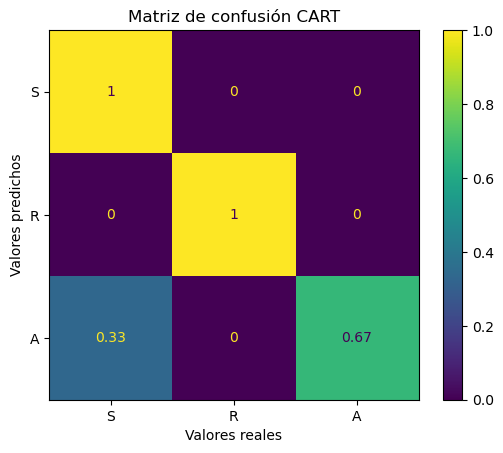

In [19]:
best_accuracy = 0
best_fold = 0
best_auc = 0.0
pliegues = []

# Obtiene las predicciones y el classification report para cada validación
for i, (train_index, test_index) in enumerate(StratifiedKFold(10).split(X, y)):
    # Separa los datos en conjuntos de entrenamiento y prueba para la i-ésima validación
    X_train_cv, X_test_cv = X[train_index], X[test_index]
    y_train_cv, y_test_cv = y[train_index], y[test_index]

    # Entrena el modelo con los datos de entrenamiento
    modelo.fit(X_train_cv, y_train_cv)

    # Haz predicciones en los datos de prueba
    y_pred = modelo.predict(X_test_cv)
    
    # Haz predicciones y calcular la pertenencia para cada clase
    y_pred_proba = modelo.predict_proba(X_test_cv)

    # Calcula el accuracy para las predicciones
    accuracy = accuracy_score(y_test_cv, y_pred)
    
    # Calcula el AUC para las predicciones
    auc = roc_auc_score(y_test_cv, y_pred_proba, average = None, multi_class = 'ovr')

    # Actualiza el mejor fold si el accuracy actual es mayor que el anterior
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_fold = i
        best_report = metrics.classification_report(y_test_cv, y_pred, zero_division=1)

        etiquetas = ["S", "R", "A"]
        matriz_c = confusion_matrix(y_test_cv, y_pred, 
                                    labels = modelo.classes_,
                                    normalize = 'true' )
        display = ConfusionMatrixDisplay(confusion_matrix = matriz_c,
                                 display_labels = etiquetas)
        best_auc = auc

    # Imprime el accuracy para la i-ésima validación
    
    print("Accuracy para el pliegue %d: %0.2f " % (i, accuracy))
    
    #Guardar los ACC de cada pliegue
    pliegues.append(accuracy)

# Imprime el fold con el mejor accuracy
print("\nMejor pliegue: %d, Accuracy: %0.2f" % (best_fold, best_accuracy))
print("Desviación estándar: (+/-) %0.2f" % np.std(pliegues))

# Imprime el classification report para el mejor fold
print("\nMétricas de desempeño para el mejor pliegue:")
print(best_report)

print("\nMatriz de confusión para el mejor pliegue:")

fig, ax = plt.subplots()
display.plot(ax=ax)
ax.set_title("Matriz de confusión CART")
ax.set_xlabel("Valores reales")
ax.set_ylabel("Valores predichos")
plt.show()

Como es un conjunto de datos pequeño, el entrenamiento fue rápido

### Árbol de decisión

De acuerdo al modelo obtenido a partir de la mejor partición, se generará el árbol de decisión gráfico, así como los umbrales impresos. Para eso se utilizó la función `plot_tree`.

Y para guardar las reglas de decisión en texto, se utilizó la función `export_text`.

AUC para la clase A: 0.86
AUC para la clase R: 1.00
AUC para la clase S: 0.86


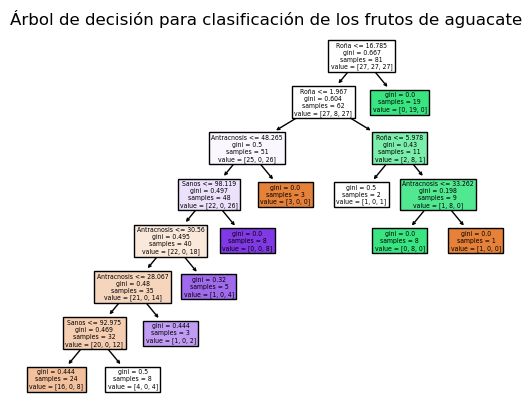


Reglas de decisión:
|--- Roña <= 16.79
|   |--- Roña <= 1.97
|   |   |--- Antracnosis <= 48.27
|   |   |   |--- Sanos <= 98.12
|   |   |   |   |--- Antracnosis <= 30.56
|   |   |   |   |   |--- Antracnosis <= 28.07
|   |   |   |   |   |   |--- Sanos <= 92.97
|   |   |   |   |   |   |   |--- class: A
|   |   |   |   |   |   |--- Sanos >  92.97
|   |   |   |   |   |   |   |--- class: A
|   |   |   |   |   |--- Antracnosis >  28.07
|   |   |   |   |   |   |--- class: S
|   |   |   |   |--- Antracnosis >  30.56
|   |   |   |   |   |--- class: S
|   |   |   |--- Sanos >  98.12
|   |   |   |   |--- class: S
|   |   |--- Antracnosis >  48.27
|   |   |   |--- class: A
|   |--- Roña >  1.97
|   |   |--- Roña <= 5.98
|   |   |   |--- class: A
|   |   |--- Roña >  5.98
|   |   |   |--- Antracnosis <= 33.26
|   |   |   |   |--- class: R
|   |   |   |--- Antracnosis >  33.26
|   |   |   |   |--- class: A
|--- Roña >  16.79
|   |--- class: R



In [20]:
# Imprime el AUC para cada clase en el mejor fold
for clase, auc_score in zip(modelo.classes_, best_auc):
    auc_formatted = "{:.2f}".format(auc_score)
    print(f"AUC para la clase {clase}: {auc_formatted}")

# Genera el árbol de decisión 
feature_names = ['Sanos', 'Roña', 'Antracnosis']
plot_tree(modelo, filled=True, feature_names = feature_names)
plt.title("Árbol de decisión para clasificación de los frutos de aguacate")
plt.show()



decision_rules = export_text(modelo, feature_names = feature_names)
print("\nReglas de decisión:")
print(decision_rules)


De manera general, el índice de Gini, indica la impureza que hay en cada umbral de decisión. Donde lo deseado es un valor de $Gini = 0$, que índica que hubo una separación de datos entre clases.

Por último, con base a estas reglas de decisión, se hará una modificación al archivo <u>4 Identificación de enfermedades.ipynb</u>, donde se generará una columna de clasificación para todas las imágenes que entren al modelo.